# Convert Seismogram to WAV file

## Import Python Packages

In [1]:
%reload_ext autoreload
%autoreload 2
# Access to operation system functionality.
import os

# Third party packages
# Plotting.
import matplotlib as mpl
import matplotlib.pyplot as plt
# Numerical computation.
import numpy as np
# Scientific computation.
import scipy as sp
# Seismological data handling and processing.
import obspy
# Audio processing.
import pedalboard as pb

## Notebook Configuration

In [2]:
config = {}
config['data_dir'] = '../data'
config['fig_dir'] = '../figures'

## Load the seismogram to convert

In [3]:
# The file has been exported in script iris_data_request.
in_filename = 'seismogram_export.msd'
in_filepath = os.path.join(config['data_dir'],
                           in_filename)
st = obspy.read(in_filepath)

ERROR! Session/line number was not unique in database. History logging moved to new session 21


In [4]:
# Print the number of traces in the stream.
# It should contain one trace.
len(st)

1

In [5]:
# Print metadata of the trace.
st[0].stats

         network: IU
         station: PMG
        location: 10
         channel: BHZ
       starttime: 2024-08-08T04:42:55.219538Z
         endtime: 2024-08-08T11:42:55.194538Z
   sampling_rate: 40.0
           delta: 0.025
            npts: 1008000
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'M', 'number_of_records': 3173, 'encoding': 'STEIM2', 'byteorder': '>', 'record_length': 512, 'filesize': 1624576})

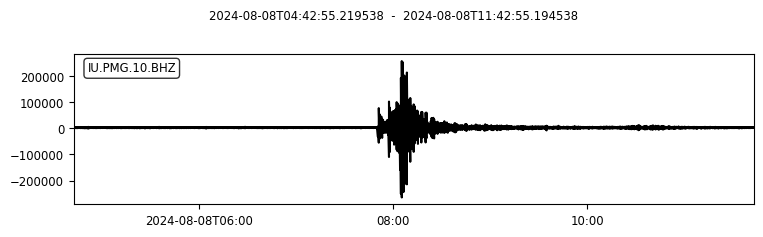

In [6]:
# Plot the seismogram.
st.plot()
plt.show()

## Normalize the trace
Recompute the amplitudes to a range between -1 and 1.

In [7]:
st = st.normalize()

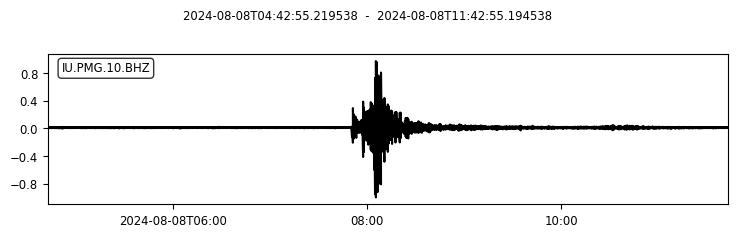

In [8]:
st.plot()
plt.show()

## Export plain data in WAV format

In [9]:
# Export with original sampling rate.
out_filename = 'seismogram_export_orig.wav'
out_filepath = os.path.join(config['data_dir'],
                            out_filename)

# The output framerate has to be set, otherwise it defaults to 7000.
# It's not using the sampling_rate of the trace data.
sps = st[0].stats.sampling_rate
output_framerate = sps

st.write(out_filepath,
         format = 'WAV',
         framerate = sps,
         rescale = True)

In [10]:
# Export with time compression by sampling rate change.
out_filename = 'seismogram_export_speed_up.wav'
out_filepath = os.path.join(config['data_dir'],
                            out_filename)
speed_up = 400
sps = st[0].stats.sampling_rate
output_framerate = sps * speed_up
st.write(out_filepath,
         format = 'WAV',
         framerate = output_framerate,
         rescale = True)

In [11]:
output_framerate

16000.0

In [12]:
test = st.copy()

In [13]:
test[0].stats.sampling_rate = output_framerate

In [14]:
test[0].stats.endtime - test[0].stats.starttime

62.999938

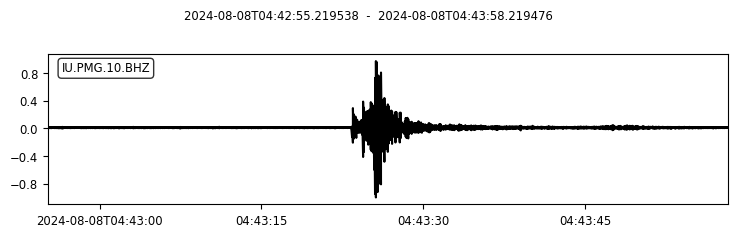

In [15]:
test[0].plot()
plt.show()

## Speedup and Compress the seismogram

I'm speeding up the seismogram data by changeing the sampling rate. Then I resample/interpolate the data to the audio samplingrate. The compression is done using the pedalboard package.

In [16]:
# Work on a copy of the trace.
trace = st[0].copy()

# Factor to speedup.
speed_up = 400

# Frequency filtering parameters.
frequ_min = 0.001
frequ_max = 10

audio_sps = 44100

# Demean and bandpass filter the data.
trace.detrend('demean')
trace.filter('bandpass',
             freqmin = frequ_min,
             freqmax = frequ_max,
             zerophase = True)

# Speed up by changing the sampling rate.
speedup_sps = trace.stats.sampling_rate * speed_up
trace.stats.sampling_rate = speedup_sps

# Interpolate of resample data to the audio sampling rate.
# Needed to process with pedalboard.
if speedup_sps <= audio_sps:
    # Interpolate to the audio sps.
    trace.interpolate(sampling_rate = audio_sps,
                      method = 'lanczos',
                      a = 20)
else:
    # Resample to the audio sps.
    trace.resample(audio_sps,
                   window = 'hann')
# Normalize
trace.normalize()
trace.taper(0.01)

IU.PMG.10.BHZ | 2024-08-08T04:42:55.219538Z - 2024-08-08T04:43:58.219470Z | 44100.0 Hz, 2778298 samples

In [17]:
trace.stats.endtime - trace.stats.starttime

62.999932

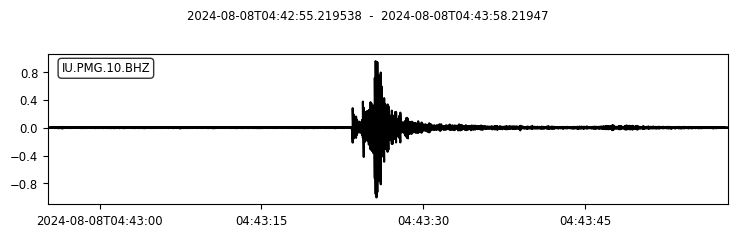

In [18]:
trace.plot()
plt.show()

In [19]:
trace.stats

         network: IU
         station: PMG
        location: 10
         channel: BHZ
       starttime: 2024-08-08T04:42:55.219538Z
         endtime: 2024-08-08T04:43:58.219470Z
   sampling_rate: 44100.0
           delta: 2.2675736961451248e-05
            npts: 2778298
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'M', 'number_of_records': 3173, 'encoding': 'STEIM2', 'byteorder': '>', 'record_length': 512, 'filesize': 1624576})
      processing: ['ObsPy 1.4.1: normalize(norm=None)', "ObsPy 1.4.1: detrend(options={}::type='demean')", "ObsPy 1.4.1: filter(options={'freqmin': 0.001, 'freqmax': 10, 'zerophase': True}::type='bandpass')", "ObsPy 1.4.1: interpolate(a=20::args=()::method='lanczos'::npts=None::sampling_rate=44100::starttime=None::time_shift=0.0)", 'ObsPy 1.4.1: normalize(norm=None)', "ObsPy 1.4.1: taper(max_length=None::max_percentage=0.01::side='both'::type='hann')"]

## Compress data
Reduce the dynamic range by compressing the data.

In [20]:
audio = trace.data
threshold_db = -35
ratio = 9
attack_ms = 5
release_ms = 100
board = pb.Pedalboard([pb.Compressor(threshold_db = threshold_db,
                                     ratio = ratio,
                                     attack_ms = attack_ms,
                                     release_ms = release_ms)])
effected = board(audio, 44100)

# Normalize the amplitude
effected = effected / np.max(np.abs(effected))
trace.data = effected

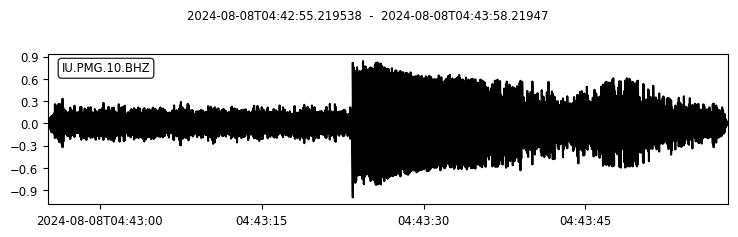

In [21]:
trace.plot()
plt.show()

## Export the processed data

In [22]:
out_filename = 'seismogram_export_processed.wav'
out_filepath = os.path.join(config['data_dir'],
                            out_filename)

# The output framerate has to be set, otherwise it defaults to 7000.
# It's not using the sampling_rate of the trace data.
trace.write(out_filepath,
            format = 'WAV',
            framerate = audio_sps,
            rescale = True)